In [1]:
include("src/SimFunctions.jl")
include("src/PlotFunctions.jl")
using Profile

In [47]:
using BenchmarkTools
q = @SVector [0.,0,0]
p = @SVector [1.,2.,3.]

3-element SVector{3, Float64} with indices SOneTo(3):
 1.0
 2.0
 3.0

In [3]:
G = @SMatrix [0. 0. 0.;
	 0. 0. 0.;
	 1. 0. 0.]
k_density_spinon_dispersion = 30
k_density_specweight=10


path_spinons = generate_path(geom.high_symmetry_points, 
	    split("\\Gamma X W K \\Gamma L U W"), 
		points_per_unit=k_density_spinon_dispersion, K_units=2π/8)
	
path = generate_path(geom.high_symmetry_points, 
	    split("\\Gamma X W K \\Gamma L U W"),
		points_per_unit=k_density_specweight, K_units=4π/8)


data_dir = "tmp"

"tmp"

In [4]:
# α should be a 3 x 4 matrix such that 
# A_μ (I_i e_i ) = I_i α_iμ
function construct_landau_gauge(lattice::geom.PyroPrimitive, α)
    A_tet_sites = geom.A_sites(lattice)
    
    A = zeros(Float64, length(A_tet_sites),4)
    for (J, tA) in enumerate(A_tet_sites)
        I, _ = geom.tetra_IDX(lattice, tA) # The three-tuple that does the thing
        A[J,:] = I' * α
    end
    # consistency
    println(exp.(1im* lat.L'*α))
    # @assert all(abs.(exp.(1im* lat.L'*α) .- 1.) .< 1e-10)
    return A
end

construct_landau_gauge (generic function with 1 method)

In [5]:
# 0 flux
sim = SimulationParameters("TEST-0flux", 
    lattice=geom.PyroPrimitive(1,1,1),
    A=[0 0 0 0],
    Jpm = -0.04,
    B=[0,0,0]
    )
λ = calc_lambda(sim)

0.1351605109892234

In [6]:
lat = geom.PyroPrimitive(2,2,1)
calc_fluxes(lat, construct_landau_gauge(lat, [π 0 π 0; π 0 0 0; 0 0 0 0]))

ComplexF64[1.0 - 4.898587196589413e-16im 1.0 - 0.0im 1.0 - 2.4492935982947064e-16im 1.0 - 0.0im]


4×4 Matrix{Float64}:
  3.14159   3.14159  -3.14159  -3.14159
  3.14159  -3.14159  -3.14159   3.14159
 -3.14159   3.14159   3.14159  -3.14159
 -3.14159  -3.14159   3.14159   3.14159

In [7]:
# pipi00 flux
sim = SimulationParameters("TEST-pipi00", 
    lattice=geom.PyroPrimitive(1,2,1),
    A=[π 0 0 0; 0 π 0 0],
    Jpm = -0.04,
    B=[0.02,0.02,0]
    )
λ = calc_lambda(sim)

0.13366729006077077

In [43]:
# pi-flux
lat = geom.PyroPrimitive(2,2,1)
A_piflux = construct_landau_gauge(lat, [0 0 0 π; 0 π 0 π; 0 0 0 0])
calc_fluxes(lat, A_piflux)


ComplexF64[1.0 - 0.0im 1.0 - 2.4492935982947064e-16im 1.0 - 0.0im 1.0 - 4.898587196589413e-16im]


4×4 Matrix{Float64}:
 -3.14159  -3.14159   3.14159   3.14159
 -3.14159   3.14159   3.14159  -3.14159
  3.14159  -3.14159  -3.14159   3.14159
  3.14159   3.14159  -3.14159  -3.14159

Plotting spinon dispersions...


Spinon Dispersion: 100%|████████████████████████████████| Time: 0:00:00


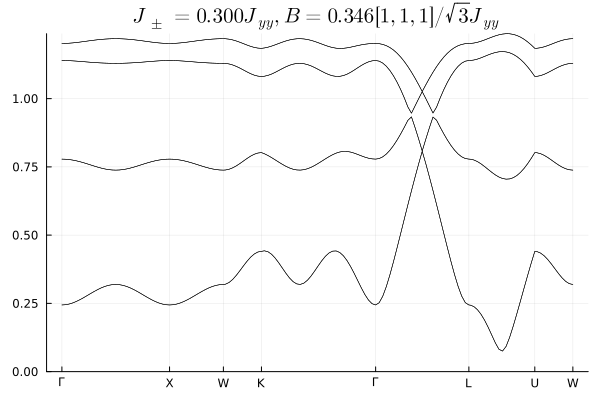

In [44]:
println("Plotting spinon dispersions...")


sim = SimulationParameters("TEST-piflux", 
    lattice=lat,
    A=A_piflux,
    Jpm = 0.3,
    B=[0.2,0.2,0.2]
    )
λ = calc_lambda(sim)
# compute spinons
d = calc_spinons_along_path(data_dir, sim=sim, λ=λ, path=path_spinons)
	
p = plot_spinons(load(d))


In [6]:

	# autorange this based on the spinon dispersion
max_E = 3.2
Egrid = collect(range(0,max_E,150)); # TODO consider updating this based on broadening_dE
datafiles = []

Any[]

In [26]:
@benchmark SpinonStructure.Lorentzian(0.5, 0.01)


BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  0.875 ns … 28.084 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     0.958 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   0.968 ns ±  0.508 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                              █▁                              
  ▂▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▂
  0.875 ns       Histogram: frequency by time        1.04 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [6]:
@benchmark corr_at(q, p, sim, λ)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  57.000 μs …  3.852 ms  ┊ GC (min … max): 0.00% … 97.50%
 Time  (median):     57.958 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   61.598 μs ± 83.363 μs  ┊ GC (mean ± σ):  5.38% ±  4.10%

       ▃▂██▆                                                   
  ▂▂▃▄████████▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂ ▃
  57 μs           Histogram: frequency by time        63.7 μs <

 Memory estimate: 84.94 KiB, allocs estimate: 1842.

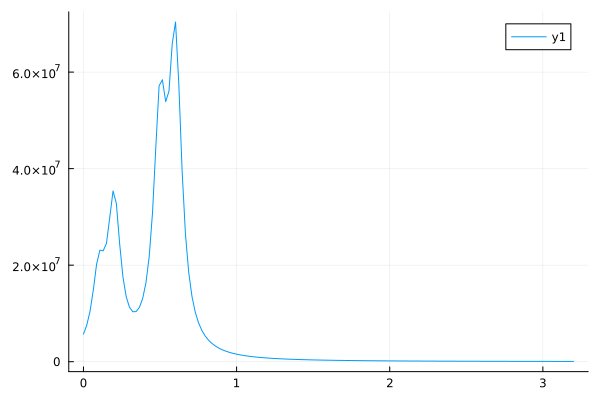

In [14]:
plot(Egrid, real(Sqω))

In [28]:

@benchmark spectral_weight(q, collect(range(0.,4.,50)), sim, λ, integration_settings["fast"])


LoadError: UndefVarError: `sim` not defined

In [13]:
@benchmark spectral_weight(q, collect(range(0.,4.,50)), sim, λ, integration_settings["slow"])


LoadError: MethodError: no method matching copyto!(::ComplexF64, ::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Tuple{}, typeof(+), Tuple{ComplexF64, ComplexF64}})

[0mClosest candidates are:
[0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted{<:Base.Broadcast.AbstractArrayStyle{0}})
[0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:959[24m[39m
[0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted)
[0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:956[24m[39m
[0m  copyto!([91m::AbstractArray[39m, ::Any)
[0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:940[24m[39m


In [14]:
Profile.clear()

@benchmark calc_spectral_weight_along_path(data_dir, 
	    sim=sim,
        λ=λ,
	    ip=integration_settings["very_fast"], 
	    Egrid=Egrid, path=path, g_tensor=G)
	    # f = data_dir*"/SQW"*sim_identifier(sim)*".jld"



LoadError: TaskFailedException

[91m    nested task error: [39mMethodError: no method matching copyto!(::ComplexF64, ::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Tuple{}, typeof(+), Tuple{ComplexF64, ComplexF64}})
    
    [0mClosest candidates are:
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted{<:Base.Broadcast.AbstractArrayStyle{0}})
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:959[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted)
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:956[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Any)
    [0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:940[24m[39m
    
    Stacktrace:
     [1] [0m[1mmacro expansion[22m
    [90m   @[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSimFunctions.jl:181[24m[39m[90m [inlined][39m
     [2] [0m[1m(::var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [3] [0m[1m#78#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [4] [0m[1m(::Base.Threads.var"#1#2"{var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m
    
    [91mcaused by: [39mMethodError: no method matching copyto!(::ComplexF64, ::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Tuple{}, typeof(+), Tuple{ComplexF64, ComplexF64}})
    
    [0mClosest candidates are:
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted{<:Base.Broadcast.AbstractArrayStyle{0}})
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:959[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted)
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:956[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Any)
    [0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:940[24m[39m
    
    Stacktrace:
     [1] [0m[1mspectral_weight![22m[0m[1m([22m[90mintensity[39m::[0mSqω_set, [90mq[39m::[0mSVector[90m{3, Float64}[39m, [90msim[39m::[0mSimulationParameters, [90mλ[39m::[0mFloat64, [90mintegral_params[39m::[0mIntegrationParameters, [90mg_tensor[39m::[0mSMatrix[90m{3, 3, Float64, 9}[39m[0m[1m)[22m
    [90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:563[24m[39m
     [2] [0m[1mmacro expansion[22m
    [90m   @[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSimFunctions.jl:172[24m[39m[90m [inlined][39m
     [3] [0m[1m(::var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [4] [0m[1m#78#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [5] [0m[1m(::Base.Threads.var"#1#2"{var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m
    
    [91mcaused by: [39mMethodError: no method matching copyto!(::ComplexF64, ::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Tuple{}, typeof(+), Tuple{ComplexF64, ComplexF64}})
    
    [0mClosest candidates are:
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted{<:Base.Broadcast.AbstractArrayStyle{0}})
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:959[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Base.Broadcast.Broadcasted)
    [0m[90m   @[39m [90mBase[39m [90m[4mbroadcast.jl:956[24m[39m
    [0m  copyto!([91m::AbstractArray[39m, ::Any)
    [0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:940[24m[39m
    
    Stacktrace:
     [1] [0m[1mmaterialize![22m
    [90m   @[39m [90m./[39m[90m[4mbroadcast.jl:914[24m[39m[90m [inlined][39m
     [2] [0m[1mmaterialize![22m
    [90m   @[39m [90m./[39m[90m[4mbroadcast.jl:911[24m[39m[90m [inlined][39m
     [3] [0m[1mbroadened_peaks![22m[0m[1m([22m[90mSqω[39m::[0mVector[90m{ComplexF64}[39m, [90mSnm[39m::[0mMatrix[90m{ComplexF64}[39m, [90mEnm[39m::[0mMatrix[90m{Float64}[39m, [90mEgrid[39m::[0mVector[90m{Float64}[39m, [90mdE[39m::[0mFloat64[0m[1m)[22m
    [90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:448[24m[39m
     [4] [0m[1mspectral_weight![22m[0m[1m([22m[90mintensity[39m::[0mSqω_set, [90mq[39m::[0mSVector[90m{3, Float64}[39m, [90msim[39m::[0mSimulationParameters, [90mλ[39m::[0mFloat64, [90mintegral_params[39m::[0mIntegrationParameters, [90mg_tensor[39m::[0mSMatrix[90m{3, 3, Float64, 9}[39m[0m[1m)[22m
    [90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:546[24m[39m
     [5] [0m[1mmacro expansion[22m
    [90m   @[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSimFunctions.jl:172[24m[39m[90m [inlined][39m
     [6] [0m[1m(::var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [7] [0m[1m#78#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [8] [0m[1m(::Base.Threads.var"#1#2"{var"#78#threadsfor_fun#12"{var"#78#threadsfor_fun#11#13"{SimulationParameters, Float64, IntegrationParameters, BZPath, SMatrix{3, 3, Float64, 9}, Sqω_set, Progress, Matrix{Float64}, Matrix{Float64}, Matrix{ComplexF64}, Matrix{ComplexF64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

...and 3 more exceptions.


In [15]:
data = load(f)

LoadError: UndefVarError: `f` not defined

In [16]:
heatmap(real(data["intensity"]["Spm"])')

LoadError: UndefVarError: `data` not defined

In [17]:
heatmap(imag(data["intensity"]["Spm"])')

LoadError: UndefVarError: `data` not defined

In [18]:
heatmap(real(data["intensity"]["Spp"])')

LoadError: UndefVarError: `data` not defined

In [19]:
heatmap(imag(data["intensity"]["Spp"])')

LoadError: UndefVarError: `data` not defined

In [45]:
@benchmark geom.tetra_idx(sim.lat, sim.lat.tetra_sites[1])

BenchmarkTools.Trial: 10000 samples with 516 evaluations.
 Range (min … max):  218.992 ns …   5.921 μs  ┊ GC (min … max): 0.00% … 95.58%
 Time  (median):     221.172 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   237.465 ns ± 276.962 ns  ┊ GC (mean ± σ):  6.01% ±  4.94%

  ▁▆█▇▄▂▁ ▂▃▃                                                   ▁
  ███████████████▇▇▇▆▆▅▇▇▆▆▇▆▇▆▆▆▄▇▄▅▆▅▅▅▅▄▅▆▄▅▅▅▅▄▅▄▅▃▅▄▄▅▄▅▄▄ █
  219 ns        Histogram: log(frequency) by time        265 ns <

 Memory estimate: 240 bytes, allocs estimate: 4.

In [41]:
sim.lat.tetra_sites

2-element Vector{SVector{3, Int64}}:
 [0, 0, 0]
 [2, 2, 2]

In [48]:


# Profile.clear()


@benchmark corr_at(q, p, sim, λ, SMatrix{3,3}([1. 0 0; 0 1 0; 0 0 1])) 


BenchmarkTools.Trial: 2114 samples with 1 evaluation.
 Range (min … max):  1.844 ms …   4.182 ms  ┊ GC (min … max): 0.00% … 34.20%
 Time  (median):     2.252 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.364 ms ± 406.923 μs  ┊ GC (mean ± σ):  4.52% ±  9.85%

          ▃▅██▇▆▃▂                                             
  ▂▁▂▂▂▄▆█████████▇▅▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▂▂▃▃▃▃▃▃▃▃▃ ▃
  1.84 ms         Histogram: frequency by time        3.82 ms <

 Memory estimate: 3.51 MiB, allocs estimate: 33974.

In [49]:
@benchmark corr_at(q, p, sim, λ, nothing)

BenchmarkTools.Trial: 3565 samples with 1 evaluation.
 Range (min … max):  1.194 ms …  16.694 ms  ┊ GC (min … max): 0.00% …  0.00%
 Time  (median):     1.303 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.401 ms ± 415.089 μs  ┊ GC (mean ± σ):  4.25% ± 10.05%

   █▇▇▃▂                                                       
  ▅█████▇▆▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▂▂ ▃
  1.19 ms         Histogram: frequency by time        2.81 ms <

 Memory estimate: 1.95 MiB, allocs estimate: 21162.

In [22]:
Profile.clear()
@profile [corr_at(q, p, sim, λ) for _ in 1:100]

Profile.print()

LoadError: MethodError: no method matching corr_at(::SVector{3, Float64}, ::Plots.Plot{Plots.GRBackend}, ::SimulationParameters, ::Float64)

[0mClosest candidates are:
[0m  corr_at(::SVector{3, Float64}, [91m::SVector{3, Float64}[39m, ::SimulationParameters, ::Float64)
[0m[90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:356[24m[39m
[0m  corr_at(::SVector{3, Float64}, [91m::SVector{3, Float64}[39m, ::SimulationParameters, ::Float64, [91m::Union{Nothing, SMatrix{3, 3, Float64}}[39m)
[0m[90m   @[39m [35mMain.SpinonStructure[39m [90m~/gh/spinon-calc/src/[39m[90m[4mSpinonStructure.jl:356[24m[39m


In [23]:
using ProfileView

ProfileView.view()

Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=2, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip-taskbar-hint

In [24]:
@benchmark spinon_dispersion(q, sim, λ)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  161.791 μs …  4.900 ms  ┊ GC (min … max): 0.00% … 91.93%
 Time  (median):     176.541 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   181.320 μs ± 96.188 μs  ┊ GC (mean ± σ):  1.61% ±  2.99%

              ▁▄▆▆█▇▇▆▄▂▂                                       
  ▁▁▁▁▂▂▂▂▃▃▅█████████████▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  162 μs          Histogram: frequency by time          210 μs <

 Memory estimate: 52.31 KiB, allocs estimate: 1231.

In [25]:
@benchmark geom.tetra_idx(sim.lat, SVector{3}([0,0,0]))

BenchmarkTools.Trial: 10000 samples with 950 evaluations.
 Range (min … max):   98.553 ns …   3.686 μs  ┊ GC (min … max): 0.00% … 96.77%
 Time  (median):     102.719 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   114.637 ns ± 185.729 ns  ┊ GC (mean ± σ):  9.25% ±  5.52%

   ▇█                                                            
  ▃██▅▂▁▂▂▂▁▁▃▇▆▄▃▃▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  98.6 ns          Histogram: frequency by time          131 ns <

 Memory estimate: 160 bytes, allocs estimate: 2.

In [26]:



data = load(f)
sim_x = SimulationParameters(data["physical_parameters"])
	
p = plot_spectral_weight(data,"Spm")
# savefig(p, figure_dir*"corr_S+-"*sim_identifier(sim_x)*".pdf")
	
	

LoadError: UndefVarError: `f` not defined

In [27]:

	    # p = plot_spectral_weight(data,"Spp")
	    # savefig(p, figure_dir*"corr_S++"*sim_identifier(sim_x)*".pdf")
	
	
p = plot_spectral_weight(data,"Smagnetic")
# savefig(p, figure_dir*"corr_Smagnetic"*sim_identifier(sim_x)*".pdf")

LoadError: UndefVarError: `data` not defined

In [52]:
data = load("output/int_fieldsweep?name=piflux-along?J_pm=0.300?B=[0.000,0.000,0.000].jld")
intens = data["integrated_intensity"]

Dict{String, Any} with 5 entries:
  "Spp"                      => ComplexF64[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+…
  "W"                        => [0.0, 0.0214765, 0.042953, 0.0644295, 0.085906,…
  "magnetic_field_strengths" => [0.0, 0.0102041, 0.0204082, 0.0306122, 0.040816…
  "Spm"                      => ComplexF64[901.722-4.49856e-16im 967.32-4.88287…
  "Smagnetic"                => [199.062 213.568 … 30.0913 29.3357; 193.949 207…

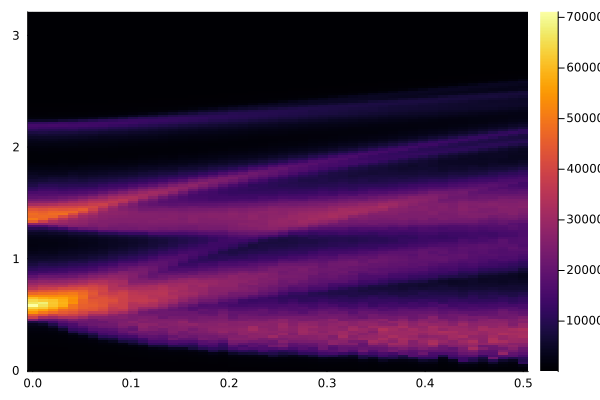

In [53]:
heatmap(intens["magnetic_field_strengths"], intens["W"],real(intens["Smagnetic"])')

In [54]:
# test the memeory requirements of corr_at for big lattices


const al1 = [ 0 0 -π/2 π/2; 0 0 0 0; 0 0 π/2 0 ]


"""
Returns the ratio of g0 to g1 in the special case B || [111], given a particular value of 
Φ0, the flux on plaquette 0 
The other three plaquettes have flux -Φ0/3
"""
g0_g123_ratio_from_flux(desired_Φ0) = (1-4*cos(desired_Φ0/3)^2)^-1

"""
FF_111_B(desired_Φ, Jpm)
-> B

x = g0/g1 <0

Returns the (111) field needed to realise the prescribed flux
"""
function FF_111_B(desired_Φ0, Jpm)
    # x = Φ0 -> ( 1 - 2*cos((π/2 - Φ0)*2/3) )^-1;
    xp = g0_g123_ratio_from_flux(desired_Φ0)
    
    B = sqrt(Jpm* 6*(1-xp)/ (xp*5/9 - 5) )
    return B
end



function sim_factory(N::Int, Jpm::Float64)
    lat = geom.PyroPrimitive(4*N,1,4*N)

    A_FF = construct_landau_gauge(lat, al1/N)

    flux_state=calc_fluxes(lat, A_FF)

    mean_fluxes = sum.(eachcol(flux_state))/size(flux_state,1)

    # check homogeneity
    max_err = sqrt(maximum((flux_state .- mean_fluxes').^2))
    println("Largest deviation from mean flux is ", max_err)


    Φ0 = abs(mean_fluxes[1])
    println("$(N) -> phi = $(Φ0)")

    return SimulationParameters("TEST_FF",
        A=A_FF, 
        lattice=lat,
        Jpm=Jpm,
        B=FF_111_B(Φ0, Jpm)* [1.,1.,1.]/sqrt(3),
        n_samples=1000,
        kappa=2.0
        )
end

sim_factory (generic function with 1 method)

In [61]:
sim_FF = sim_factory(2, -0.04)

ComplexF64[1.0 - 0.0im 1.0 - 0.0im 0.7071067811865476 - 0.7071067811865475im 6.123233995736766e-17 + 1.0im]
Largest deviation from mean flux is 1.7763568394002505e-15
2 -> phi = 2.356194490192344


SimulationParameters([0.0 0.0 0.0 0.0; 0.0 0.0 0.7853981633974483 0.0; … ; 0.0 0.0 -0.7853981633974483 5.497787143782138; 0.0 0.0 0.0 5.497787143782138], -0.04, [0.16970562748477136, 0.16970562748477136, 0.16970562748477136], Main.SpinonStructure.PyrochloreGeometry.PyroPrimitive([8, 1, 8], SVector{3, Int64}[[0, 0, 0], [4, 4, 0], [8, 8, 0], [12, 12, 0], [16, 16, 0], [20, 20, 0], [24, 24, 0], [28, 28, 0], [0, 4, 4], [4, 8, 4]  …  [26, 50, 26], [30, 54, 26], [2, 30, 30], [6, 34, 30], [10, 38, 30], [14, 42, 30], [18, 46, 30], [22, 50, 30], [26, 54, 30], [30, 58, 30]], SVector{3, Int64}[[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1], [5, 5, 1], [5, 3, -1], [3, 5, -1], [3, 3, 1], [9, 9, 1], [9, 7, -1]  …  [19, 49, 27], [19, 47, 29], [25, 53, 29], [25, 51, 27], [23, 53, 27], [23, 51, 29], [29, 57, 29], [29, 55, 27], [27, 57, 27], [27, 55, 29]]), 2.0, 1000, "TEST_FF")

In [62]:
@benchmark corr_at(q, p, sim_FF, 11.)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 6.419 s (25.20% GC) to evaluate,
 with a memory estimate of 34.89 GiB, over 4953694 allocations.

In [63]:

function sim_factory(N::Int, Jpm::Float64)
    lat = geom.PyroPrimitive(4*N,1,4*N)

    A_FF = construct_landau_gauge(lat, al1/N)

    flux_state=calc_fluxes(lat, A_FF)

    mean_fluxes = sum.(eachcol(flux_state))/size(flux_state,1)

    # check homogeneity
    max_err = sqrt(maximum((flux_state .- mean_fluxes').^2))
    println("Largest deviation from mean flux is ", max_err)


    Φ0 = abs(mean_fluxes[1])
    println("$(N) -> phi = $(Φ0)")

    return SimulationParameters("TEST_FF",
        A=A_FF, 
        lattice=lat,
        Jpm=Jpm,
        B=FF_111_B(Φ0, Jpm)* [1.,1.,1.]/sqrt(3),
        n_samples=1000,
        kappa=2.0
        )
end

sim_factory (generic function with 1 method)

In [67]:
s = sim_factory(3,-0.04)

calc_fluxes(s.lat, s.A)/π

ComplexF64[1.0 - 0.0im 1.0 - 0.0im 0.8660254037844387 - 0.49999999999999994im 0.5000000000000001 + 0.8660254037844386im]
Largest deviation from mean flux is 2.4424906541753444e-15
3 -> phi = 1.5707963267948972


144×4 Matrix{Float64}:
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
  ⋮                        
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667
 -0.5  0.166667  0.166667  0.166667

In [79]:
Egrid = collect(range(0,2,1000))
Sqω = zeros(ComplexF64, 1000)
Snm = rand(4,4) + 1im*rand(4,4)
Enm = rand(4,4)

@benchmark broadened_peaks!(Sqω, Snm, Enm,Egrid,0.02)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  10.666 μs …  39.541 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     10.791 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.820 μs ± 744.382 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

          █   ▇                                                 
  ▂▁▁▁▃▁▁▁█▁▁▁█▁▁▁▁▄▁▁▁▃▁▁▁▂▁▁▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▂ ▂
  10.7 μs         Histogram: frequency by time         11.2 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [68]:
rand(4,4)

4×4 Matrix{Float64}:
 0.325332  0.74799   0.365872  0.223628
 0.510527  0.268533  0.519522  0.0987111
 0.592227  0.73373   0.634778  0.122856
 0.20721   0.559249  0.64718   0.126261